In [7]:
# Create a directory for the Kaggle file
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the Kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions to read and write
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d imbikramsaha/food11

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/food11
License(s): CC0-1.0
 97% 502M/519M [00:04<00:00, 180MB/s]
100% 519M/519M [00:04<00:00, 120MB/s]


In [9]:
!unzip food11.zip

Streaming output truncated to the last 5000 lines.
  inflating: food11/train/hamburger/2722745.jpg  
  inflating: food11/train/hamburger/272642.jpg  
  inflating: food11/train/hamburger/2726558.jpg  
  inflating: food11/train/hamburger/2738245.jpg  
  inflating: food11/train/hamburger/2745577.jpg  
  inflating: food11/train/hamburger/2745917.jpg  
  inflating: food11/train/hamburger/2754513.jpg  
  inflating: food11/train/hamburger/2756964.jpg  
  inflating: food11/train/hamburger/2762170.jpg  
  inflating: food11/train/hamburger/2766731.jpg  
  inflating: food11/train/hamburger/2771605.jpg  
  inflating: food11/train/hamburger/277584.jpg  
  inflating: food11/train/hamburger/2777938.jpg  
  inflating: food11/train/hamburger/2790429.jpg  
  inflating: food11/train/hamburger/279510.jpg  
  inflating: food11/train/hamburger/2797268.jpg  
  inflating: food11/train/hamburger/279729.jpg  
  inflating: food11/train/hamburger/2808308.jpg  
  inflating: food11/train/hamburger/281725.jpg  
  in

In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

In [10]:
# Set dataset paths
train_dir = '/content/food11/train'
test_dir = '/content/food11/test'

In [11]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Load and augment data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 9900 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.


In [ ]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze the convolutional base
conv_base.trainable = False

In [ ]:
# Build the model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))  # 11 food categories

In [ ]:
# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/30
309/309 [==============================] - 111s 358ms/step - loss: 2.1110 - accuracy: 0.2878 - val_loss: 1.7902 - val_accuracy: 0.4412
Epoch 2/30
309/309 [==============================] - 110s 357ms/step - loss: 1.7584 - accuracy: 0.4245 - val_loss: 1.5759 - val_accuracy: 0.4908
Epoch 3/30
309/309 [==============================] - 110s 356ms/step - loss: 1.6128 - accuracy: 0.4754 - val_loss: 1.4745 - val_accuracy: 0.5276
Epoch 4/30
309/309 [==============================] - 110s 356ms/step - loss: 1.5330 - accuracy: 0.4979 - val_loss: 1.3949 - val_accuracy: 0.5542
Epoch 5/30
309/309 [==============================] - 110s 357ms/step - loss: 1.4709 - accuracy: 0.5192 - val_loss: 1.3571 - val_accuracy: 0.5634
Epoch 6/30
309/309 [==============================] - 110s 354ms/step - loss: 1.4395 - accuracy: 0.5301 - val_loss: 1.3394 - val_accuracy: 0.5699
Epoch 7/30
309/309 [==============================] - 109s 352ms/step - loss: 1.4054 - accuracy: 0.5400 - val_loss: 1.2895 -

In [ ]:
model.save("Food_calories.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
# Food-calorie mapping
food_calorie_map = {
    'apple_pie': 237,
    'cheesecake': 321,
    'chicken_curry': 220,
    'french_fries': 312,
    'fried_rice': 163,
    'hamburger': 295,
    'hot_dog': 150,
    'ice_cream': 207,
    'omelette': 154,
    'pizza': 266,
    'sushi': 130,
}

def estimate_calories(predicted_class):
    food_item = list(train_generator.class_indices.keys())[predicted_class]
    return food_calorie_map[food_item]

In [20]:
model = tf.keras.models.load_model('/content/Food_calories.h5')

In [14]:
def predict_and_estimate_calories(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Retrieve food item and calories
    food_item = list(train_generator.class_indices.keys())[predicted_class]
    calories = estimate_calories(predicted_class)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {food_item}\nCalories: {calories}')
    plt.show()

    return food_item, calories

1/1 [==============================] - 0s 51ms/step


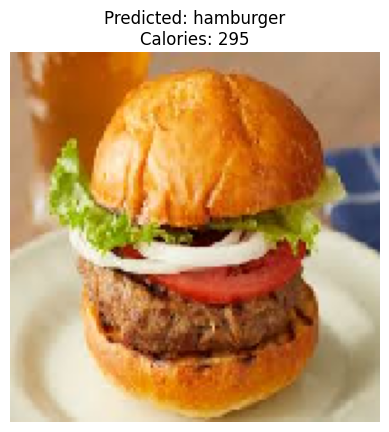

In [19]:
food_item, calories = predict_and_estimate_calories('/content/download.jpg')

Evalutaion

In [21]:
# Evaluate the model accuracy on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy:.2f}')

34/34 [==============================] - 9s 261ms/step - loss: 1.1630 - accuracy: 0.6425
Test Accuracy: 0.64


35/35 [==============================] - 9s 259ms/step


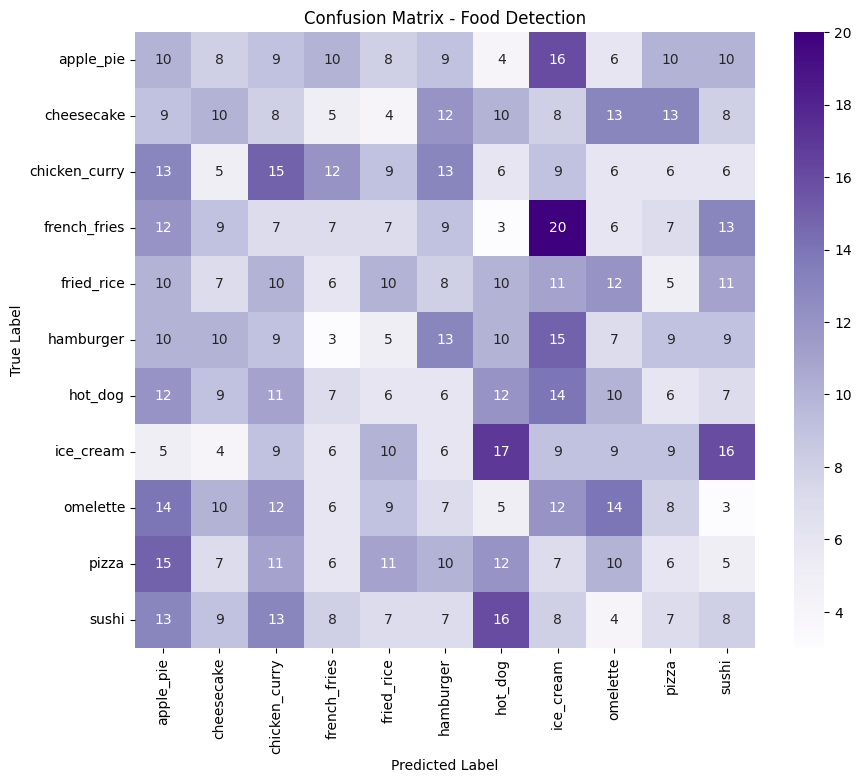

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the exact number of steps needed for the test set
steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)

# Reset the test generator
test_generator.reset()

# Extract class names from the generator
class_names = list(test_generator.class_indices.keys())

# Predict using the exact number of steps
y_pred = model.predict(test_generator, steps=steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_true is correctly aligned with the predictions
y_true = test_generator.classes[:len(y_pred_classes)]

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Food Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()